## Outlier Engineering


**An outlier** is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980]. Statistics such as the **mean and variance** are very **susceptible to outliers**. In addition, **some Machine Learning models are sensitive to outliers** which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables. Section 3 mentions how to identify outliers. Now, we discuss how we can **process them** to train our machine learning models. These are: **Trimming:** remove the outliers from our dataset; **Treat outliers as missing data,** and proceed with **any missing data imputation** technique; **Discrestisation:** outliers are placed in border bins together with higher or lower values of the distribution; **Censoring:** capping the variable distribution at a max and / or minimum value! **Censoring** is also known as: **top and bottom coding**, **winsorization** or **capping**.


## Censoring or Capping.

**Censoring**, or **capping**, means capping the maximum and /or minimum of a distribution at an arbitrary value. On other words, values bigger or smaller than the arbitrarily determined ones are **censored**. The numbers at which to cap the distribution can be determined: **arbitrarily**, or using the **inter-quantal range proximity** rule, or using the **gaussian approximation**, or using **quantiles!**


It does **not remove data** (advandage!). But distorts the distributions of the variables, and distorts the relationships among variables! It is important to remember that the capping values **MUST be derived from the train set**. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # for Q-Q plots
from sklearn.datasets import load_boston
from feature_engine.outliers import Winsorizer

**Load the the Boston House price data from sklearn! Create a dataframe with the independent variables!**

In [2]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
    columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston['MEDV'] = boston_dataset.target  # add the target
boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


**Function to create histogram, Q-Q plot and boxplot.**

In [3]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4)) # define figure size
    plt.subplot(1, 3, 1)  # histogram
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)  # Q-Q plot
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.subplot(1, 3, 3)  # boxplot
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

**Find outliers in RM !**

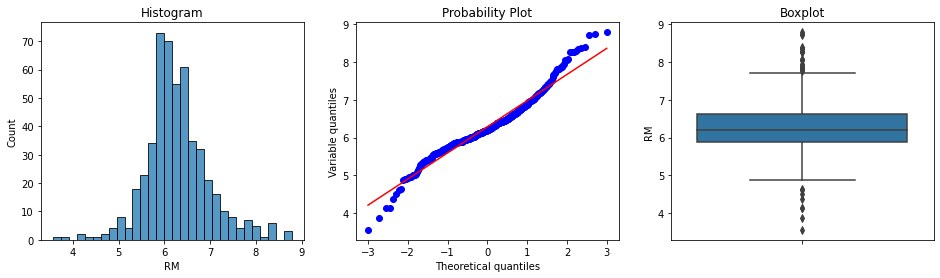

In [4]:
diagnostic_plots(boston, 'RM')

**Visualise outliers in LSTAT !**

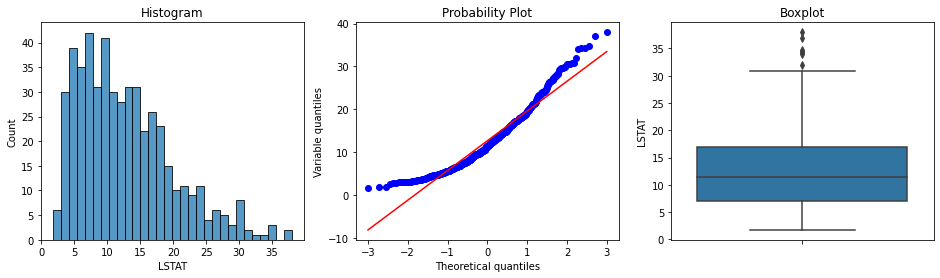

In [5]:
diagnostic_plots(boston, 'LSTAT')

**Outliers in CRIM !**

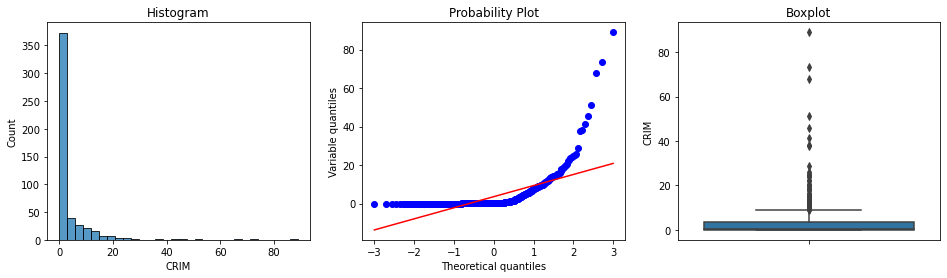

In [6]:
diagnostic_plots(boston, 'CRIM')

There are outliers in all of the above variables. RM shows outliers in both tails, whereas LSTAT and CRIM only on the right tail.

To find the outliers, let's re-utilise the function we learned in section 3:

**Calculate the boundaries outside which sit the outliers for skewed distributions! Choose 1.5 times or 3 times the IQR to calculate the boundaries!**

In [7]:
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

**Lind limits for RM !**

In [8]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

**Limits for LSTAT !**

In [9]:
LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

**Limits for CRIM !**

In [10]:
CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

**Replace the outliers by the maximum and minimum limit!**

In [11]:
boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
    np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

**Replace the outliers by the maximum and minimum limit!**

In [12]:
boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

**Replace the outliers by the maximum and minimum limit!**

In [13]:
boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
        np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

**Explore outliers in the trimmed dataset for RM we see much less outliers as in the original dataset!**

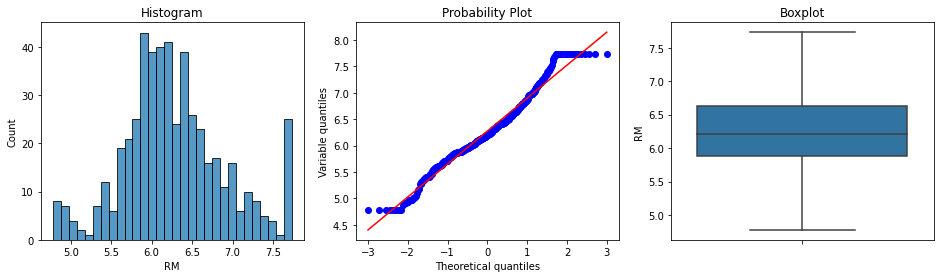

In [14]:
diagnostic_plots(boston, 'RM')

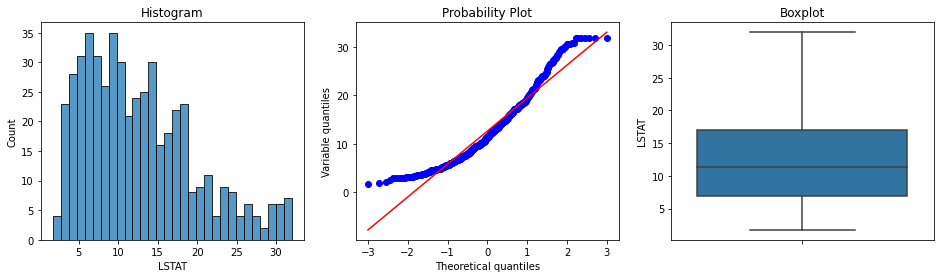

In [15]:
diagnostic_plots(boston, 'LSTAT')

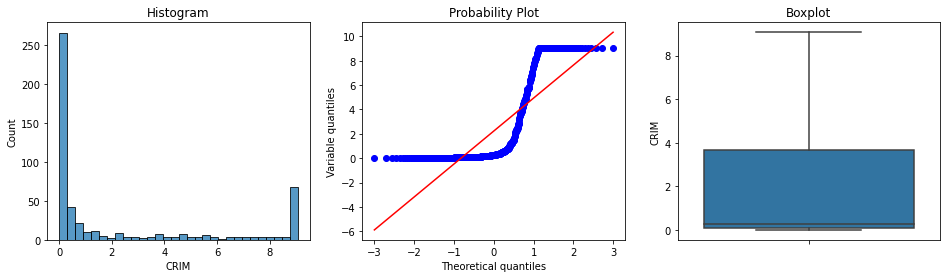

In [16]:
diagnostic_plots(boston, 'CRIM')

We can see that the outliers are gone, but the variable distribution was distorted quite a bit.

## Censoring with Feature-engine

**Load the the Boston House price data from sklearn! Create a dataframe with the independent variables!**

In [17]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
    columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston['MEDV'] = boston_dataset.target  # add the target
boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


**Create the capper!**

In [18]:
windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['RM', 'LSTAT', 'CRIM'])
windsoriser.fit(boston)

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [19]:
boston_t = windsoriser.transform(boston)

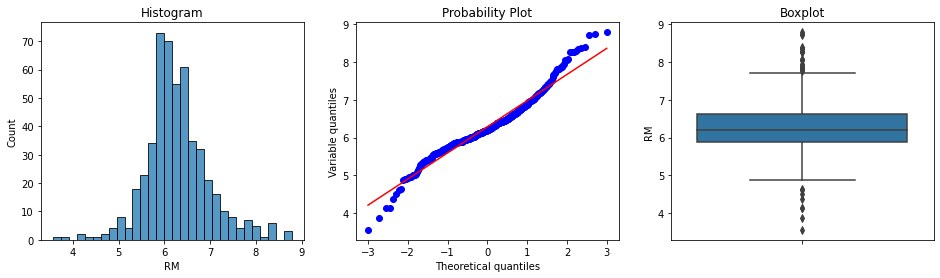

In [20]:
diagnostic_plots(boston, 'RM')

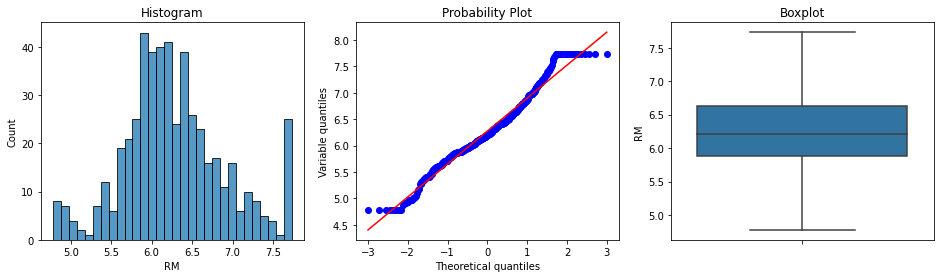

In [21]:
diagnostic_plots(boston_t, 'RM')

**Inspect the minimum caps for each variable!**

In [22]:
windsoriser.left_tail_caps_

{'RM': 4.778499999999999, 'LSTAT': -8.057500000000005, 'CRIM': -5.31051125}

**Inspect the maximum caps for each variable!**

In [23]:
windsoriser.right_tail_caps_

{'RM': 7.730500000000001, 'LSTAT': 31.962500000000006, 'CRIM': 9.06963875}